
# NVIDIA NIMs with Tool Calling for Agents

This notebook will use a [NVIDIA Llama 3.1 NIM](https://developer.nvidia.com/blog/supercharging-llama-3-1-across-nvidia-platforms/) with tool-calling agent capabilities in generative AI solutions. As mentioned in this [Introductory Blog on LLM Agents](https://developer.nvidia.com/blog/introduction-to-llm-agents/), agents can be described as AI systems that use LLMs to reason through a problem, create a plan to solve the problem, execute the plan with the help of a set of tools, and use memory to store meaningful context of the system state. 

The notebook is designed to provide an intro to merely one of the capabilities of agent systems: **tool calling**. 

**Tools** are interfaces that accept input, execute an action, and then return a result of that action in a structured output according to a pre-defined schema. They often encompass external API calls that the agent can use to perform tasks that go beyond the capabilities of the LLM, but do not have to be external API calls. For example, to get the current weather in San Diego, a weather tool might be used. Or to get the current score of the 49ers game, a generic web search tool or ESPN tool might be used. 

## What is NVIDIA NIM and How do They Support Tool Calling for Agents?
### What is NIM?
NIM supports models across domains like chat, embedding, and re-ranking models 
from the community as well as NVIDIA. These models are optimized by NVIDIA to deliver the best performance on NVIDIA 
accelerated infrastructure and deployed as a NIM, an easy-to-use, prebuilt containers that deploy anywhere using a single 
command on NVIDIA accelerated infrastructure. If you're new to NIMs with LangChain, check out the [documentation](https://python.langchain.com/v0.2/docs/integrations/providers/nvidia/).

Now, NIMs support tool calling, also known as "function calling" for models that have the aforementioned capability. 

This notebook will demonstrate a model that supports function calling, [Llama 3.1 8b-instruct](https://build.nvidia.com/meta/llama-3_1-8b-instruct). 

### What does it mean for NIM to support tool usage?
In order to support tool usage in an agent workflow, first an LLM must be trained to detect when a function should be called and output a structured response like JSON that contains the function to be called and its arguments. 

Next, the model is packaged as a NIM, meaning it's optimized to deliver best performance on NVIDIA accelerated infrastructure and easy to deploy as well as use. This microservice packaging also uses OpenAI compatible APIs, so developers can build world-class generative AI agents with ease.

Let's see how to use tools in a couple of examples.

### Prerequisites
- an [NVIDIA API key](https://build.nvidia.com/explore/discover#llama-3_1-8b-instruct) with access to download the Llama3.1 NIM on NGC,
- NGC CLI, Docker and NVIDIA Container Toolkit (setup in cells below),
- Tool-calling capable NIM hosted here **or** a NIM hosted by NVIDIA (setup in cells below)

Note: NIMs hosted [from NVIDIA](https://build.nvidia.com/explore/discover) can be used for exploratory purposes. More information on integrating NIMs with LangChain is available on [LangChain's documentation](https://python.langchain.com/v0.2/docs/integrations/chat/nvidia_ai_endpoints/). 

#### 1) Download the NIM and run it locally

If you've run this in a previous notebook, no need to run it again!

In [ ]:
%%bash 

export NGC_API_KEY=

# Log in to NGC
echo "${NGC_API_KEY}" | docker login nvcr.io -u '$oauthtoken' --password-stdin

# Set path to your LoRA model store
export LOCAL_PEFT_DIRECTORY="$(pwd)/loras"
mkdir -p $LOCAL_PEFT_DIRECTORY
pushd $LOCAL_PEFT_DIRECTORY
popd

chmod -R 777 $LOCAL_PEFT_DIRECTORY

# Set up NIM cache directory
mkdir -p $HOME/.nim-cache

export NIM_PEFT_SOURCE=/workspace/loras # Path to LoRA models internal to the container
export CONTAINER_NAME=meta-llama3_1-8b-instruct
export NIM_CACHE_PATH=$HOME/.nim-cache
export NIM_PEFT_REFRESH_INTERVAL=60

docker run -d --name=$CONTAINER_NAME \
    --network=container:verb-workspace \
    --runtime=nvidia \
    --gpus all \
    --shm-size=16GB \
    -e NGC_API_KEY \
    -e NIM_PEFT_SOURCE \
    -e NIM_PEFT_REFRESH_INTERVAL \
    -v $HOME/.nim-cache:/home/user/.nim-cache \
    -v /home/ubuntu/workspace:/workspace \
    -w /workspace \
    nvcr.io/nim/meta/llama-3.1-8b-instruct:1.1.0

# Check if NIM is up
echo "Checking if NIM is up..."
while true; do
    if curl -s http://localhost:8000 > /dev/null; then
        echo "NIM has been started successfully!"
        break
    else
        echo "NIM is not up yet. Checking again in 10 seconds..."
        sleep 10
    fi
done

##  🔨 Tool Usage -- Web Search

Since a LLM does not have access to the most up-to-date information on the Internet, [Tavily Search](https://docs.tavily.com/docs/tavily-api/introduction) acts as a tool to provide a generative AI application with real-time online information.  Tavily is a search engmine that is optimized for AI developers and AI agents. A singular API call abstracts searching, scraping, filtering, and extracting relevant information from online sources. 

We'll enhance our NIM, [Llama 3.1-8b-instruct](https://build.nvidia.com/meta/llama-3_1-8b-instruct), with Tavily search. 

Install pre-requesites. 

In [1]:
%pip install -U langchain langgraph langchain-nvidia-ai-endpoints langchain-community langchain-openai tavily-python geocoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 6.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.0/384.0 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.5/776.5 kB 66.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.1.29
    Uninstalling langchain-core-0.1.29:
      Successfully uninstalled langchain-core-0.1.29
  Attempting uninstall: langchain-text-splitters
    Found existing in

Declare your model that supports tool calling. In this example, we use [Llama 3.1-8b-instruct](https://build.nvidia.com/meta/llama-3_1-8b-instruct). 

In [2]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

llm = ChatNVIDIA(model="meta/llama-3_1-8b-instruct",
                base_url="http://localhost:8000/v1")

# if you do not have a downloaded NIM hosted (done in the prerequisites in this notebook)
# you can use NVIDIA's hosted NIMs capable of tool calling. Uncomment the snippet below and
# be sure your API key is set.
# llm = ChatNVIDIA(model="meta/llama-3.1-8b-instruct")

Initialize [Tavily Tool](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/)

Note that this requires an API key - they have a free tier, but if you don't have one or don't want to create one, you can always ignore this step or use a different tool. 

Once you create your API key, you will need to set it in the environment.

In [4]:
import getpass
import os

os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

Enter your Tavily API key:  ········


In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Declare a single tool, Tavily search
tools = [TavilySearchResults(max_results=1)]

Create [ReAct agent](https://python.langchain.com/v0.2/docs/concepts/#react-agents), prebuilt in [LangGraph](https://langchain-ai.github.io/langgraph/#overview). 

In [6]:
from langgraph.prebuilt import create_react_agent
from langchain.callbacks.tracers import ConsoleCallbackHandler

app = create_react_agent(llm, tools)

Run agent; a callback is passed to provide more verbose output.

In [7]:
query = "What is the weather in Paris, France right now?"
messages = app.invoke({"messages": [("human", query)]}, config={'callbacks': [ConsoleCallbackHandler()]})
{
    "input": query,
    "output": messages["messages"][-1].content,
}

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "messages": [
    [
      "human",
      "What is the weather in Paris, France right now?"
    ]
  ]
}
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
{
  "messages": [
    [
      "human",
      "What is the weather in Paris, France right now?"
    ]
  ]
}
[chain/end] [chain:LangGraph > chain:__start__] s] Exiting Chain run with output:
{
  "messages": [
    [
      "human",
      "What is the weather in Paris, France right now?"
    ]
  ]
}
[chain/start] [chain:LangGraph > chain:agent] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent > chain:call_model] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent > chain:call_model > chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent > chain:call_model > chain:RunnableSequence > chain:StateModifier] Entering Chain run w

{'input': 'What is the weather in Paris, France right now?',
 'output': "I'm sorry, but I cannot access current weather data. I can provide general information about Paris and its weather patterns."}

## 🔨 Tool Usage -- Adding on a Custom Tool

Let's see how to [define a custom tool](https://python.langchain.com/v0.2/docs/how_to/custom_tools/) for your NIM agent and how it handles multiple tools.  

We'll enhance the NIM with Tavily search with some custom tools to determine a user's current location (based on IP address) and return a latitude and longitude. We will use these tools to have Tavily look up the weather in the user's current location.

First, let's create a custom tool to determine a user's location based off IP address. 

In [8]:
import geocoder
from langchain.tools import tool
from typing import Tuple

@tool
def get_current_location() -> list:
    """Return the current location of the user based on IP address"""
    loc = geocoder.ip('me')
    return loc.latlng    

Let's update the tools to use the Tavily tool delcared earlier and also add the `get_current_location` tool.

In [9]:
# Declare two tools: Tavily and custom get_current_location tool.
tools = [TavilySearchResults(max_results=1), get_current_location]

We already declared our LLM, so we don't need to redeclare it. However, we do want to update the agent to have the updated tools.

In [10]:
from langgraph.prebuilt import create_react_agent
from langchain.globals import set_verbose
from langchain.callbacks.tracers import ConsoleCallbackHandler

set_verbose(True) # verbose output to follow function calling

query = "What is the weather?"
app = create_react_agent(llm, tools)


messages = app.invoke({"messages": [("human", query)]}, config={'callbacks': [ConsoleCallbackHandler()]})
{
    "input": query,
    "output": messages["messages"][-1].content,
}

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "messages": [
    [
      "human",
      "What is the weather?"
    ]
  ]
}
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
{
  "messages": [
    [
      "human",
      "What is the weather?"
    ]
  ]
}
[chain/end] [chain:LangGraph > chain:__start__] s] Exiting Chain run with output:
{
  "messages": [
    [
      "human",
      "What is the weather?"
    ]
  ]
}
[chain/start] [chain:LangGraph > chain:agent] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent > chain:call_model] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent > chain:call_model > chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent > chain:call_model > chain:RunnableSequence > chain:StateModifier] Entering Chain run with input:
[inputs]
[chain/end] [chain:LangGraph > chain:agent > chain:call_model

{'input': 'What is the weather?',
 'output': "I can't provide real-time weather information. However, I can suggest some general information about weather if that helps. Can I help you with anything else?"}

In order to execute this query, first a tool to get the current location needs to be called. Then a tool to get the current weather at that location needs to be called. 
Finally, the result is returned to the user.

Below, you can see a diagram of the application's graph. The agent continues to use tools until the query is resolved.

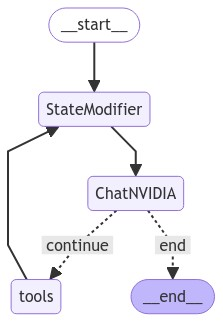

In [11]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## Conclusion
You've now seen how to use NIMs to do tool calling, an important capability of agents. As mentioned earlier, tools are just one part of agent capabilities, so check out other notebook so see how tools can be used with othe techniques to create agent workflows.

If you're ready to explore more complicated agent workflows, check out [this blog](https://developer.nvidia.com/blog/build-an-agentic-rag-pipeline-with-llama-3-1-and-nvidia-nemo-retriever-nims/) on how to improve your RAG pipeline with agents with Llama 3.1 and NVIDIA NemMo Retriever NIMs.